<a href="https://colab.research.google.com/github/LujainOwaimer/exam/blob/main/Copy_of_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 72.2MB/s]
Archive:  traffic-dataset.zip
replace Traffic Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime as dt
import matplotlib.dates as mdates
import math
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, GRU, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [45]:
df = pd.read_csv('/content/Traffic Data.csv')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [4]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [5]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [6]:
df.sort_values(by='date_time', inplace=True)
df.head()


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00


In [7]:
df['rain_1h'].value_counts()

,count
rain_1h,
0.00,19287
0.25,269
1.78,68
1.02,29
2.79,17
...,...
0.43,2
0.71,2
0.64,2


In [8]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [6]:
#df['Year'] = df['date_time'].dt.year
#df['Month'] = df['date_time'].dt.month

In [7]:
#df['Year'].value_counts()

,count
Year,
2017,10605
2018,7949
2016,1446


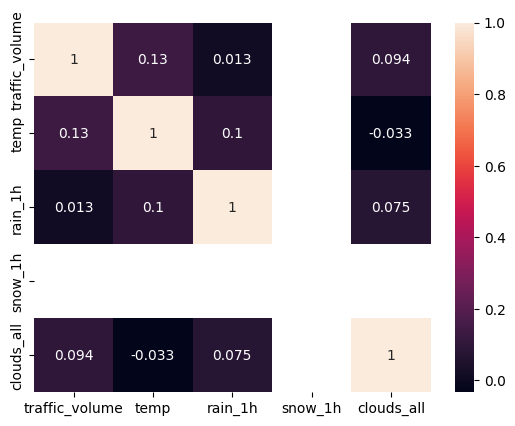

In [9]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [10]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000,20000
mean,3278.186887,281.162680,0.048395,0.0,49.384600,2017-10-22 04:13:17.939999744
min,113.000000,243.390000,0.000000,0.0,0.000000,2016-11-18 15:00:00
25%,1228.750000,271.950000,0.000000,0.0,1.000000,2017-04-30 14:45:00
50%,3430.000000,281.825000,0.000000,0.0,75.000000,2017-10-21 07:30:00
75%,4928.000000,291.840000,0.000000,0.0,90.000000,2018-04-13 21:00:00
max,16781.000000,310.070000,10.600000,0.0,92.000000,2018-09-30 23:00:00
std,1977.171357,12.661288,0.398007,0.0,39.647341,NaN


In [11]:
df.sort_values(by='date_time', inplace=True)

In [12]:
tra_vol_split= df.head(500)

<ipython-input-13-fbb5c3de38b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tra_vol_split['date_time'] = pd.to_datetime(tra_vol_split['date_time'])


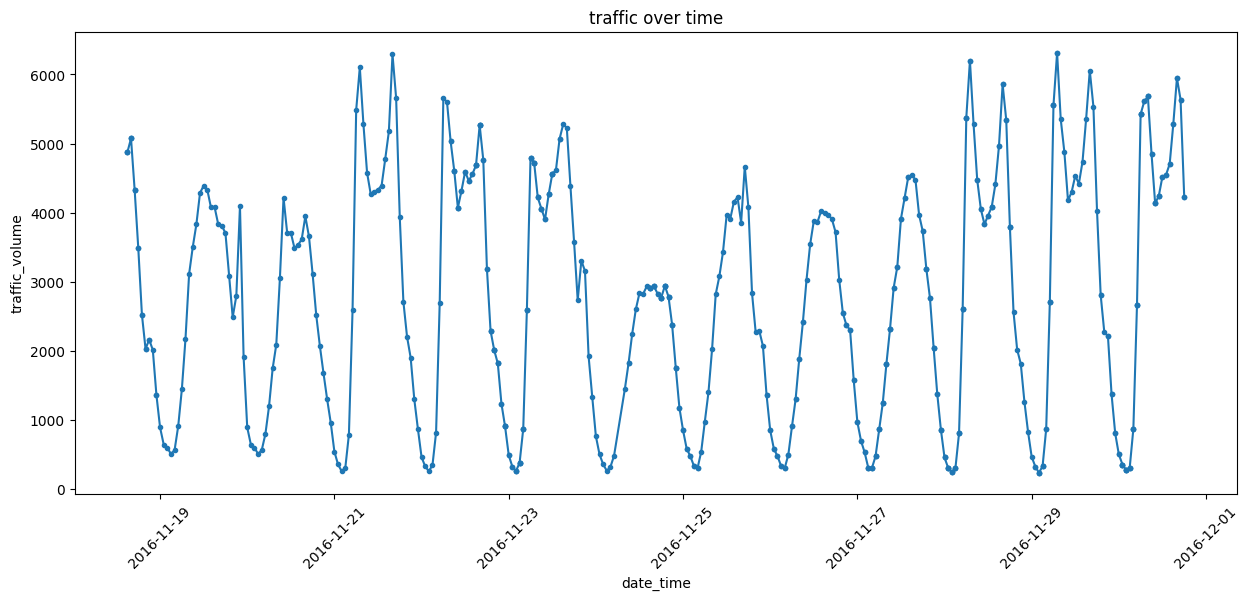

In [13]:
tra_vol_split['date_time'] = pd.to_datetime(tra_vol_split['date_time'])

plt.figure(figsize=(15, 6))
plt.plot(tra_vol_split['date_time'], tra_vol_split['traffic_volume'], marker='.')
plt.title('traffic over time')
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [14]:
fig = px.box(df, y='temp')
fig.show()

In [15]:
fig = px.box(df, y='traffic_volume')
fig.show()

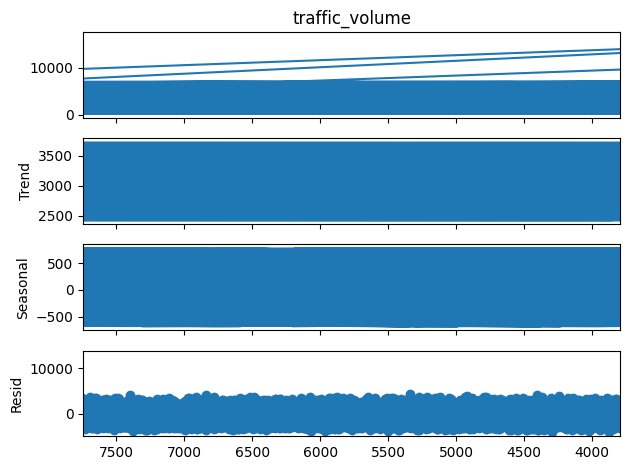

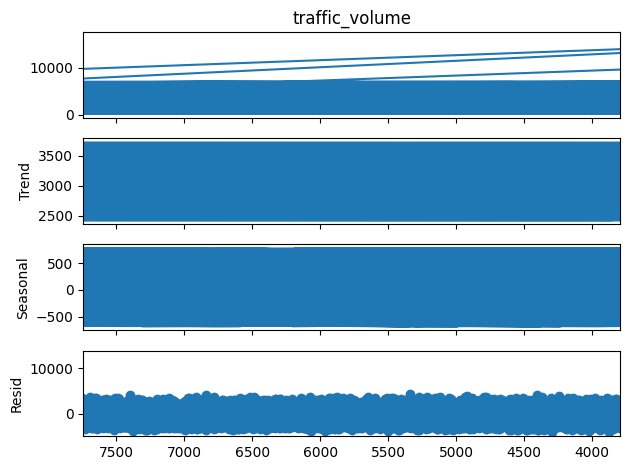

In [19]:
# ETS
result = seasonal_decompose(df['traffic_volume'],
                            model ='additive',
                            period=365)
result.plot()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [17]:
df['traffic_volume']= df['traffic_volume'].bfill().ffill()

In [18]:
#drop no needed columns
df = df.drop('weather_main',axis=1)
df=df.drop('rain_1h',axis=1)
df=df.drop('snow_1h',axis=1)



In [20]:
#handling outlliar
Q1= df['traffic_volume'].quantile(0.25)
Q3=df['traffic_volume'].quantile(0.75)
IQR = Q3-Q1
lower_bound= Q1 - 1 * IQR
upper_bound= Q3 + 1.5 * IQR
df = df[(df['traffic_volume'] >= lower_bound ) & (df['traffic_volume']<= upper_bound)]



Q1= df['temp'].quantile(0.25)
Q3=df['temp'].quantile(0.75)
IQR = Q3-Q1
lower_bound= Q1 - 0.5 *IQR
upper_bound= Q3 + 1.5 * IQR
df = df[(df['temp'] >= lower_bound ) & (df['temp']<= upper_bound)]



In [21]:
df.duplicated().sum()

11

In [22]:
df = df.drop_duplicates()

In [23]:
df.sort_values(by='date_time', inplace=True)

df.head()

,traffic_volume,temp,clouds_all,weather_description,date_time
7745,4872.0,274.08,90,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,90,fog,2016-11-18 15:00:00
14496,4872.0,274.08,90,mist,2016-11-18 15:00:00
8867,5074.0,273.84,90,fog,2016-11-18 16:00:00
3867,5074.0,273.84,90,mist,2016-11-18 16:00:00


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [29]:
new_df = df[['date_time', 'traffic_volume']]
new_df.set_index('date_time', inplace=True)

new_df['prev_traffic_volume'] = new_df['traffic_volume'].shift(1)
new_df.reset_index(inplace=True)


new_df = new_df.drop(new_df.index[0])
new_df.head()

<ipython-input-29-73cd48cb88df>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date_time,traffic_volume,prev_traffic_volume
1,2016-11-18 15:00:00,4872.0,4872.0
2,2016-11-18 15:00:00,4872.0,4872.0
3,2016-11-18 16:00:00,5074.0,4872.0
4,2016-11-18 16:00:00,5074.0,5074.0
5,2016-11-18 16:00:00,5074.0,5074.0


In [31]:
new_df.set_index('date_time', inplace=True)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [32]:
train_split = int(len(new_df) * 0.8)
train_data = new_df.iloc[:train_split]
test_data = new_df.iloc[train_split:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [34]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [35]:
X_train, y_train = create_dataset(train_data_scaled, 30)
X_test, y_test = create_dataset(test_data_scaled, 30)

In [36]:
print("Training set size:")
print(X_train.shape), print(y_train.shape)
print("Testing set size:")
print(X_test.shape), print(y_test.shape)

Training set size:
(14736, 30, 2)
(14736,)
Testing set size:
(3661, 30, 2)
(3661,)


(None, None)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [41]:
model_lstm = Sequential([
    LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    LSTM(30, return_sequences=False),
    Dropout(0.2),

    Dense(1)
])



model_lstm.compile(optimizer='adam', loss='mean_absolute_error')
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 30)              │           3,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30)                  │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,311 (44.18 KB)

 Trainable params: 11,311 (44.18 KB)

 Non-trainable params: 0 (0.00 B)

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [43]:
Checkpoint = ModelCheckpoint(filepath  = 'my_weights.lu.keras', save_best_only= True)

early_stop = EarlyStopping(monitor='val_loss', patience=15 , restore_best_weights=True)

history_2 = model_lstm.fit(X_train,y_train,
                        epochs=20,
                        callbacks = [Checkpoint , early_stop],
                        validation_data=(X_test,y_test),
                        batch_size=32)

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0409 - val_loss: 0.0328
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0407 - val_loss: 0.0321
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0403 - val_loss: 0.0303
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0398 - val_loss: 0.0307
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0402 - val_loss: 0.0296
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - loss: 0.0384 - val_loss: 0.0293
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - loss: 0.0386 - val_loss: 0.0293
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0388 - val_loss: 0.0288
Epoch 9/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0377 - val_loss: 0.0285
Epoch 10/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0375 - val_loss: 0.0289
Epoch 11/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0366 - val_loss: 0.0301
Epoch 12/20
461/461 ━━━━━━━━━━

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [46]:
# predict X_test
predicted_values_test = model_lstm.predict(X_test)

predicted_values_test_reshaped = np.hstack((predicted_values_test, np.zeros((predicted_values_test.shape[0], 1))))
predicted_values_test_rescaled = scaler.inverse_transform(predicted_values_test_reshaped)
predicted_values_test_rescaled = predicted_values_test_rescaled[:, 0]
#y_test
y_test_reshaped = np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))))
testY_rescaled = scaler.inverse_transform(y_test_reshaped)
testY_rescaled = testY_rescaled[:, 0]

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [47]:
# predict X_train
predicted_values_train = model_lstm.predict(X_train)

predicted_values_train_reshaped = np.hstack((predicted_values_train, np.zeros((predicted_values_train.shape[0], 1))))
predicted_values_train_rescaled = scaler.inverse_transform(predicted_values_train_reshaped)
predicted_values_train_rescaled = predicted_values_train_rescaled[:, 0]

#y_train
y_train_reshaped = np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))))
trainY_rescaled = scaler.inverse_transform(y_train_reshaped)
trainY_rescaled = trainY_rescaled[:, 0]


print(f'Test MAE: {mean_absolute_error(testY_rescaled, predicted_values_test_rescaled)}')
print(f'Train MAE: {mean_absolute_error(trainY_rescaled, predicted_values_train_rescaled)}')

461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Test MAE: 283.4369774534057
Train MAE: 305.6289565667397


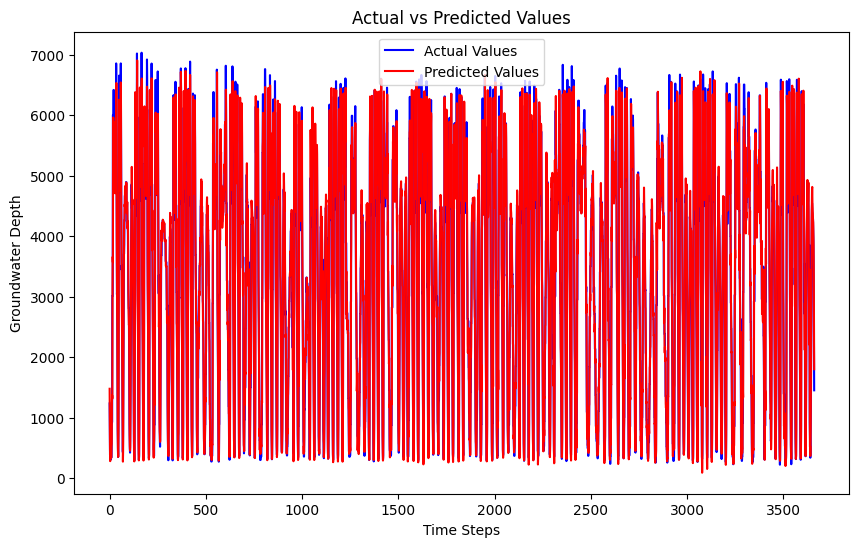

In [52]:
plt.figure(figsize=(10, 6))

plt.plot(testY_rescaled, label='Actual Values', color='blue')


plt.plot(predicted_values_test_rescaled, label='Predicted Values', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Groundwater Depth')

plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [48]:
model_rnn = Sequential([
    SimpleRNN(30,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    SimpleRNN(30,return_sequences=True),
    Dropout(0.2),

    SimpleRNN(30),
    Dense(1)
])

model_rnn.compile(optimizer='adam',loss='mean_absolute_error')

model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 30)              │             990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30, 30)              │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,681 (18.29 KB)

 Trainable params: 4,681 (18.29 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
Checkpoint = ModelCheckpoint(filepath  = 'my_weights_rnn.h5.keras', save_best_only= True)

early_stop = EarlyStopping(monitor='val_loss', patience=15 , restore_best_weights=True)

history = model_rnn.fit(X_train,y_train,
                        epochs=20,
                        callbacks = [Checkpoint , early_stop],
                        validation_data=(X_test,y_test),
                        batch_size=32)

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0372 - val_loss: 0.0310
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0377 - val_loss: 0.0288
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.0357 - val_loss: 0.0334
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0356 - val_loss: 0.0280
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0360 - val_loss: 0.0279
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0364 - val_loss: 0.0304
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0357 - val_loss: 0.0282
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0354 - val_loss: 0.0299
Epoch 9/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0362 - val_loss: 0.0352
Epoch 10/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0348 - val_loss: 0.0288
Epoch 11/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0360 - val_loss: 0.0278
Epoch 12/20
461/461 ━━━━━━━━━━

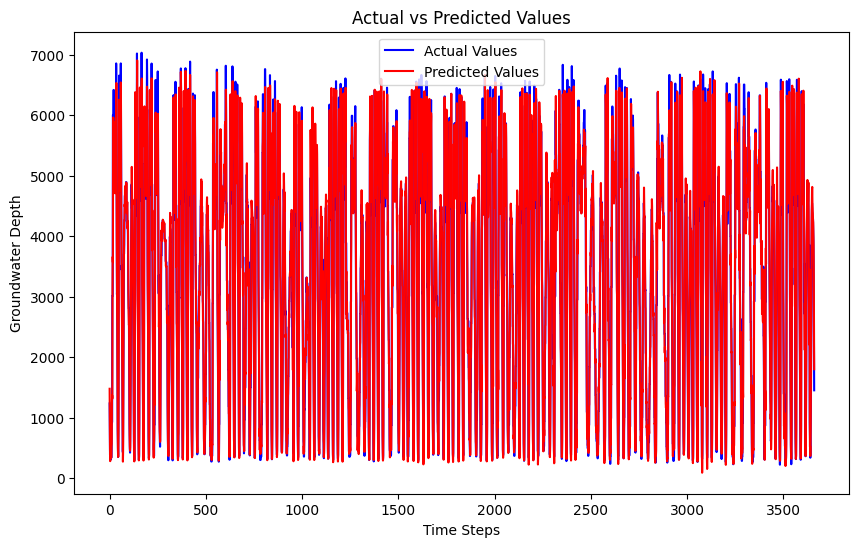

In [57]:
plt.figure(figsize=(10, 6))

plt.plot(testY_rescaled, label='Actual Values', color='blue')


plt.plot(predicted_values_test_rescaled, label='Predicted Values', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Groundwater Depth')

plt.legend()
plt.show()

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [58]:
# predict X_test
predicted_values_test = model_rnn.predict(X_test)

predicted_values_test_reshaped = np.hstack((predicted_values_test, np.zeros((predicted_values_test.shape[0], 1))))
predicted_values_test_rescaled = scaler.inverse_transform(predicted_values_test_reshaped)
predicted_values_test_rescaled = predicted_values_test_rescaled[:, 0]
#y_test
y_test_reshaped = np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))))
testY_rescaled = scaler.inverse_transform(y_test_reshaped)
testY_rescaled = testY_rescaled[:, 0]



115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [59]:
# predict X_train
predicted_values_train = model_rnn.predict(X_train)

predicted_values_train_reshaped = np.hstack((predicted_values_train, np.zeros((predicted_values_train.shape[0], 1))))
predicted_values_train_rescaled = scaler.inverse_transform(predicted_values_train_reshaped)
predicted_values_train_rescaled = predicted_values_train_rescaled[:, 0]
#y_train
y_train_reshaped = np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))))
trainY_rescaled = scaler.inverse_transform(y_train_reshaped)
trainY_rescaled = trainY_rescaled[:, 0]


print(f'Test MAE: {mean_absolute_error(testY_rescaled, predicted_values_test_rescaled)}')
print(f'Train MAE: {mean_absolute_error(trainY_rescaled, predicted_values_train_rescaled)}')

461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Test MAE: 280.8812992802835
Train MAE: 310.7343312879351


## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

ماكان عندي وقت اجاوب على الاسئلة بس ماجربت كذا ارتكتشر يادوب واحد بس